In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [346]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Data Exploration + Preprocessing

In [347]:
df = pd.read_csv('PJME_hourly.csv')

In [348]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [349]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [350]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


<Axes: title={'center': 'PJM East Energy Use in MW'}, xlabel='Datetime'>

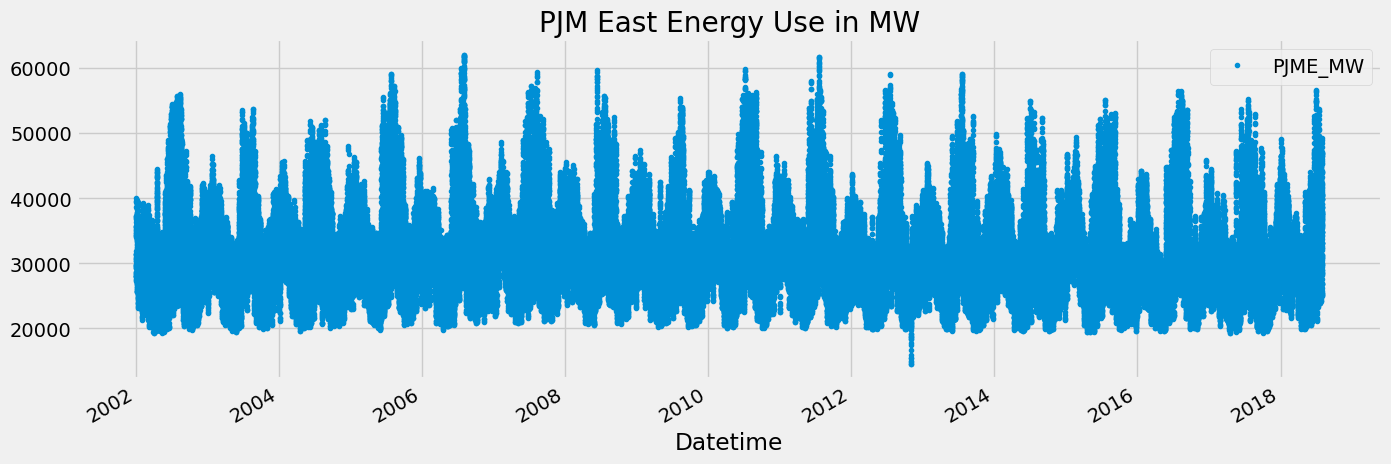

In [351]:
df = df.sort_index()

# plotting all usage data
df.plot(
    style='.', 
    figsize=(15,5), 
    color=color_pal[0], 
    title='PJM East Energy Use in MW'
)

<Axes: title={'center': 'Example Week'}, xlabel='Datetime'>

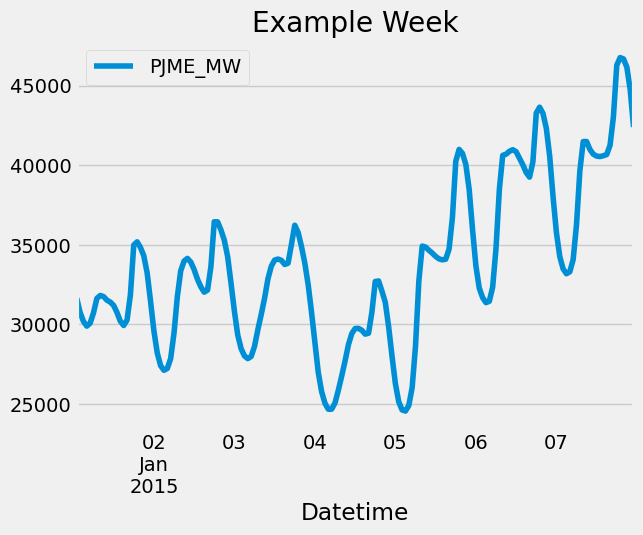

In [352]:
# plotting data for a random week (notice dip in weekends)
df.loc[(df.index > '01-01-2015') & (df.index < '01-08-2015')].plot(title='Example Week')

Creating Features

In [353]:
def create_features(df):
    """
    Create time series features based on index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    return df

In [354]:
df = create_features(df)

In [355]:
df

,PJME_MW,hour,dayofweek,quarter,month,dayofyear
Datetime,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,1
...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,214
2018-08-02 21:00:00,43256.0,21,3,3,8,214
2018-08-02 22:00:00,41552.0,22,3,3,8,214


More data exploration based on features

<Axes: xlabel='hour', ylabel='PJME_MW'>

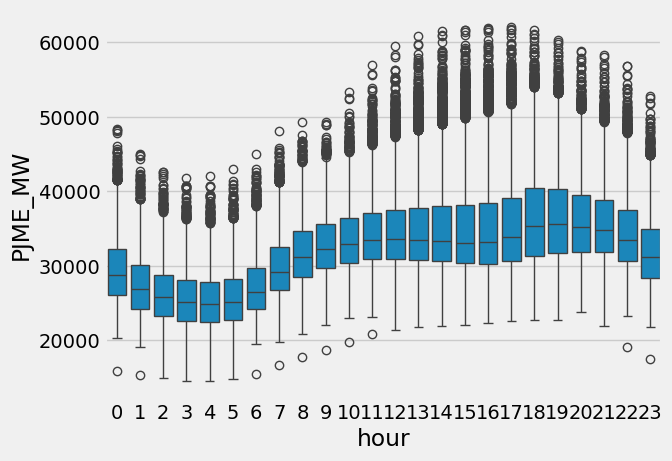

In [356]:
# Consumption based on hours of the day
sns.boxplot(data=df, x='hour', y='PJME_MW')

<Axes: xlabel='month', ylabel='PJME_MW'>

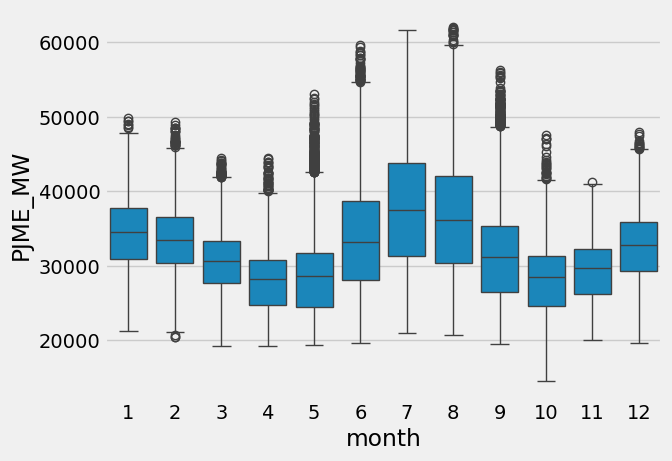

In [357]:
# Consumption based on months of the year
sns.boxplot(data=df, x='month', y='PJME_MW')

In [358]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'dayofyear'], dtype='object')

In [359]:
# Train, validation, test split
train_prop = 0.8
cut_off1 = int(train_prop * len(df))

test_prop = 0.1
cut_off2 = int((train_prop + test_prop) * len(df))

train = df[:cut_off1]
val = df[cut_off1:cut_off2]
test = df[cut_off2:]

In [360]:
train, val, test

(                     PJME_MW  hour  dayofweek  quarter  month  dayofyear
 Datetime                                                                
 2002-01-01 01:00:00  30393.0     1          1        1      1          1
 2002-01-01 02:00:00  29265.0     2          1        1      1          1
 2002-01-01 03:00:00  28357.0     3          1        1      1          1
 2002-01-01 04:00:00  27899.0     4          1        1      1          1
 2002-01-01 05:00:00  28057.0     5          1        1      1          1
 ...                      ...   ...        ...      ...    ...        ...
 2015-04-09 10:00:00  33082.0    10          3        2      4         99
 2015-04-09 11:00:00  33285.0    11          3        2      4         99
 2015-04-09 12:00:00  33148.0    12          3        2      4         99
 2015-04-09 13:00:00  32809.0    13          3        2      4         99
 2015-04-09 14:00:00  32613.0    14          3        2      4         99
 
 [116292 rows x 6 columns],
        

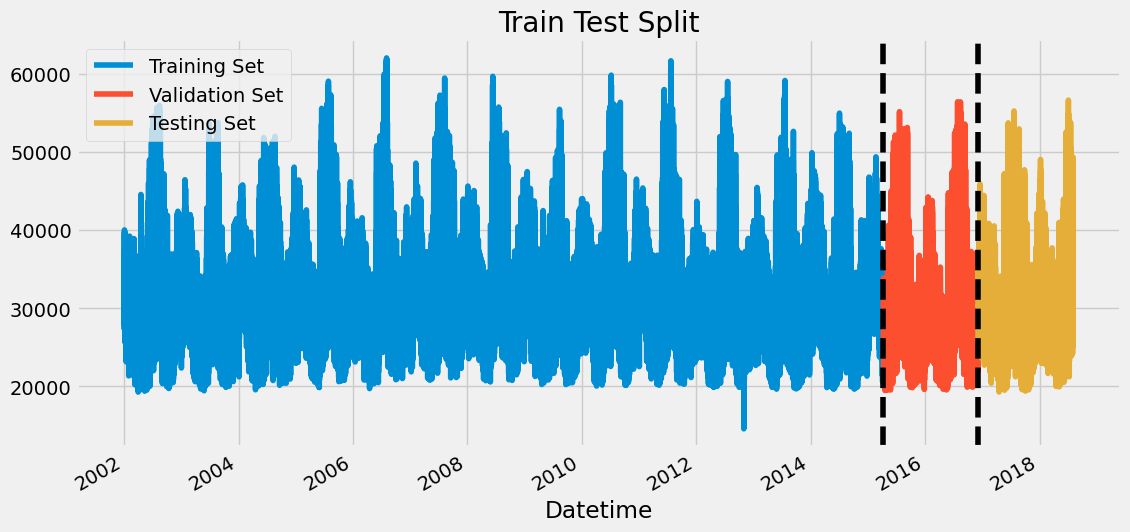

In [361]:
# visualization of how dataset is split
fig, ax = plt.subplots(figsize=(12, 6))
train['PJME_MW'].plot(label='Training Set', ax=ax, title='Train Test Split')
val['PJME_MW'].plot(label='Validation Set', ax=ax)
test['PJME_MW'].plot(label='Testing Set', ax=ax)
ax.axvline(df.index[cut_off1], color='black', ls='--')
ax.axvline(df.index[cut_off2], color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Testing Set'])

In [362]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'dayofyear']
TARGET = ['PJME_MW']

# creating features for datasets used in model training
train = create_features(train)
val = create_features(val)
test = create_features(test)

In [363]:
# Splitting inputs and outputs
X_train = train[FEATURES]
y_train = train[TARGET]

X_val = val[FEATURES]
y_val = val[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Hyperparameters Tuning

In [364]:
reg_test = xgb.XGBRegressor()

In [365]:
# hyperparameters to tune + values to test
param_grid = {
    'n_estimators': [500, 600, 750],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 9]
}

# since param_grid is small, we can use GridSearchCV to try every combination
grid_search = GridSearchCV(
    estimator=reg_test,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=5
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=500;, score=-10021376.000 total time=   0.7s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=500;, score=-11041668.000 total time=   0.6s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=500;, score=-11270537.000 total time=   0.6s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=600;, score=-9972550.000 total time=   0.7s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=600;, score=-10967785.000 total time=   0.7s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=600;, score=-11212636.000 total time=   0.7s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=750;, score=-9957137.000 total time=   1.0s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=750;, score=-10921141.000 total time=   0.9s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=750;, score=-11197755.000 total time=   0.9s
[CV 1

Modeling

In [366]:
# based on the best parameters
reg = xgb.XGBRegressor(
    **best_params,
    early_stopping_rounds=50)

In [367]:
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=50
)

[0]	validation_0-rmse:6387.54500	validation_1-rmse:6963.94544
[50]	validation_0-rmse:4686.78749	validation_1-rmse:5219.75540
[100]	validation_0-rmse:3830.41426	validation_1-rmse:4346.49920
[150]	validation_0-rmse:3413.52596	validation_1-rmse:3933.71289
[200]	validation_0-rmse:3215.20583	validation_1-rmse:3740.55881
[250]	validation_0-rmse:3116.92668	validation_1-rmse:3652.55694
[300]	validation_0-rmse:3058.34578	validation_1-rmse:3606.80418
[350]	validation_0-rmse:3021.53274	validation_1-rmse:3583.86600
[400]	validation_0-rmse:2996.93562	validation_1-rmse:3572.17577
[450]	validation_0-rmse:2974.90717	validation_1-rmse:3562.15710
[499]	validation_0-rmse:2957.27400	validation_1-rmse:3562.69715


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


Model Evaluation

In [368]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

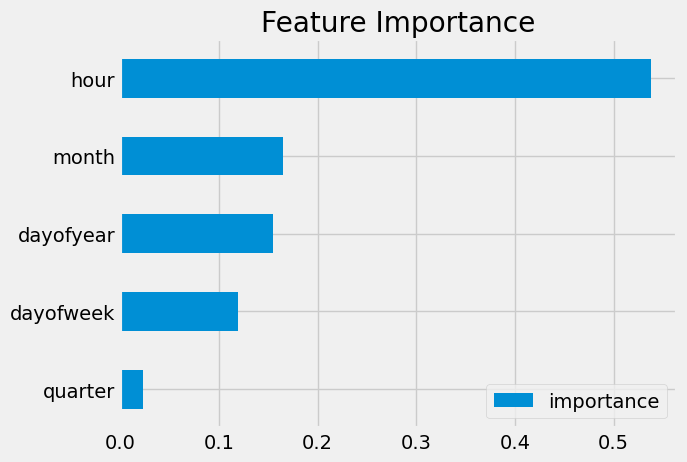

In [369]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [370]:
# Evaluate using test data
test['prediction'] = reg.predict(X_test)

# Create df to include both the expected and predicted values
df_predicted = df[['PJME_MW']].copy()
df_predicted = df_predicted.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_predicted

,PJME_MW,prediction
Datetime,,
2002-01-01 01:00:00,30393.0,NaN
2002-01-01 02:00:00,29265.0,NaN
2002-01-01 03:00:00,28357.0,NaN
2002-01-01 04:00:00,27899.0,NaN
2002-01-01 05:00:00,28057.0,NaN
...,...,...
2018-08-02 20:00:00,44057.0,45443.164062
2018-08-02 21:00:00,43256.0,44831.578125
2018-08-02 22:00:00,41552.0,43241.539062


In [371]:
df_predicted.dropna(subset=['prediction'], inplace=True)

In [372]:
df_predicted

,PJME_MW,prediction
Datetime,,
2016-12-05 07:00:00,31204.0,33365.937500
2016-12-05 08:00:00,33003.0,35375.492188
2016-12-05 09:00:00,33085.0,35565.078125
2016-12-05 10:00:00,32831.0,35572.179688
2016-12-05 11:00:00,32267.0,35505.132812
...,...,...
2018-08-02 20:00:00,44057.0,45443.164062
2018-08-02 21:00:00,43256.0,44831.578125
2018-08-02 22:00:00,41552.0,43241.539062


Text(0.5, 1.0, 'Actual Data and Predicted Data')

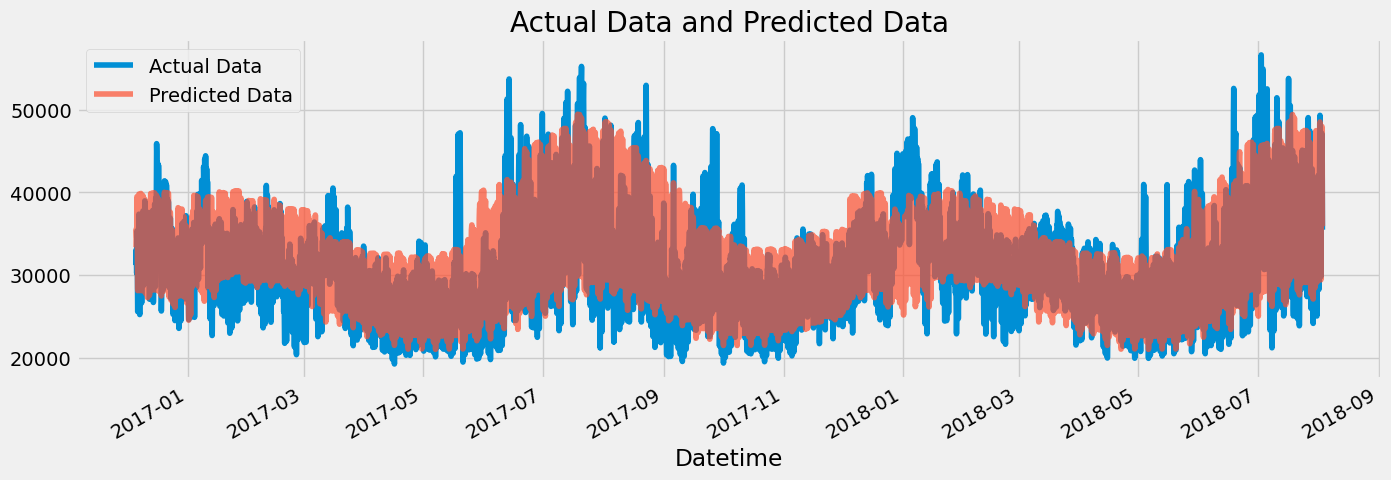

In [373]:
# Plotting actual test data against predicted test data
ax = df_predicted[['PJME_MW']].plot(figsize=(15, 5))
df_predicted['prediction'].plot(ax=ax, alpha=0.7)
plt.legend(['Actual Data', 'Predicted Data'])
ax.set_title('Actual Data and Predicted Data')

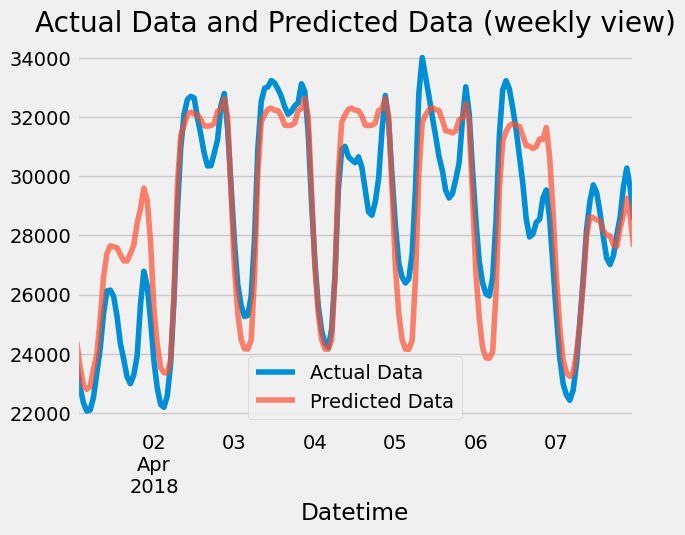

In [374]:
# zooming in on one specific week, visualization for actual vs. predicted values
start_date = pd.to_datetime('04-01-2018')
end_date = start_date + pd.Timedelta(days=7)

weekly_predicted = df_predicted.loc[((df_predicted.index > start_date) & (df_predicted.index < end_date)), ['PJME_MW', 'prediction']]
weekly_predicted.shape
ax = weekly_predicted['PJME_MW'].plot(title='Actual Data and Predicted Data (weekly view)')
weekly_predicted['prediction'].plot(ax=ax, alpha=0.7)
plt.legend(['Actual Data', 'Predicted Data'])

In [375]:
# RMSE Score based on Test data set
score = np.sqrt(mean_squared_error(df_predicted['PJME_MW'], df_predicted['prediction']))
print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 3912.55


In [376]:
# Finding the error, or difference, between the actual and predicted values
df_predicted['error'] = np.abs(df_predicted['PJME_MW'] - df_predicted['prediction'])

In [377]:
# Top 5 dates with the highest error
# All concentrated in the start of the year
df_predicted['date'] = df_predicted.index.date
df_predicted.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2018-01-06    12110.702311
2018-01-07    11734.064209
2018-01-02     9590.247559
2018-01-05     9516.114176
2018-01-01     9110.701090
Name: error, dtype: float64

In [378]:
# Top 5 dates with the lowest error
df_predicted.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2017-01-05    403.550618
2018-08-03    420.000000
2017-02-03    431.975260
2016-12-30    532.205892
2016-12-29    543.531820
Name: error, dtype: float64

In [379]:
# finding the mean absolute percentage error (accuracy)
df_predicted['error_percent'] = np.abs((df_predicted['PJME_MW'] - df_predicted['prediction']) / df_predicted['PJME_MW']) * 100

mape = df_predicted['error_percent'].mean()
print(f"Mean Absolute Percentage Error: {100 - mape:.2f}%")

Mean Absolute Percentage Error: 89.97%


Predictions!

In [380]:
years = df.index.year.unique()

def get_prediction(date=pd.Timestamp.today()):

    # creating the input dataframe for prediction
    today = date.normalize()
    hourly_index = pd.date_range(start=today, periods=24, freq='h')
    df_today = pd.DataFrame(index=hourly_index)
    df_today = create_features(df_today)

    predicted_today = reg.predict(df_today).round(2)
    df_today['prediction'] = predicted_today

    # plotting the predicted values (left plot)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    df_today['prediction'].plot(ax=axes[0], title="Prediction", color='black')

    # plotting all past data points on the same day (right plot)
    for year in years:
        day_data = df.loc[
            (df.index.year == year) &
            (df.index.month == today.month) &
            (df.index.day == today.day),
            'PJME_MW'
        ]
        if not day_data.empty:
            day_data.index = day_data.index.time
            day_data.plot(ax=axes[1], label=str(year), alpha=0.5) 

    # adding predicted values to right plot
    df_today.index = pd.to_datetime(df_today.index)
    df_today.index = df_today.index.time
    df_today['prediction'].plot(ax=axes[1], color='black', linewidth=6)

    axes[1].legend()
    axes[1].set_title('Historical vs. Predicted')

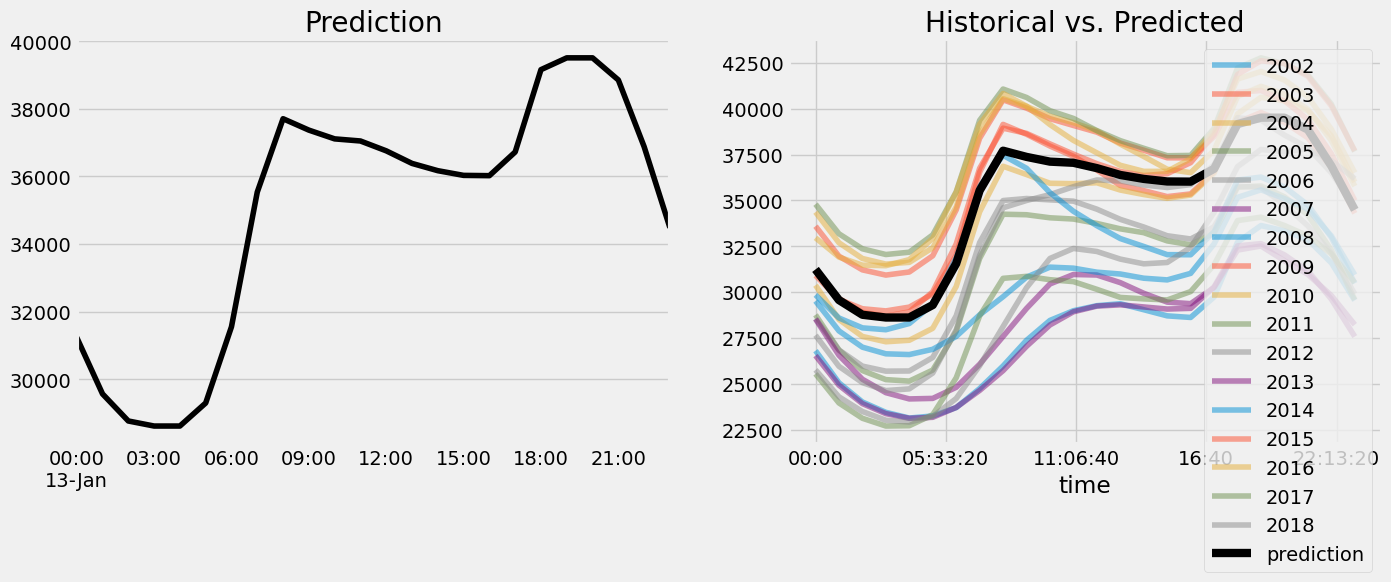

In [381]:
# ouputs the predicted per hour energy consumption for today(default)
# today's prediction is plotted against all actual values for the past years on the same month and date.
get_prediction()